# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

In [ ]:
# 필요 라이브러리부터 설치할께요.
!pip install konlpy pandas seaborn wordcloud python-mecab-ko wget transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.9/573.9 kB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 15.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=2aefc197a07dc61b4779f683eaac1ab97e7b2cd4932fb2a41b933e3d31749f78
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget,os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import wget,os

In [ ]:
# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,103 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and dire

### 1-3. 한글 글꼴 설정

In [ ]:
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 전처리한 데이터 불러오기
* 1, 2일차에 전처리한 데이터를 불러옵니다.
* sparse data에 대해서는 scipy.sparse.load_npz 활용

In [ ]:
import scipy
data_path = '/content/drive/MyDrive/미니프로젝트/4차-1_1:1문의 게시판/'
x_tr_tfidf = scipy.sparse.load_npz(data_path + 'X_tfidf_train.npz').toarray()
x_val_tfidf = scipy.sparse.load_npz(data_path + 'X_tfidf_val.npz').toarray()

y_train = np.load('/content/drive/MyDrive/미니프로젝트/4차-1_1:1문의 게시판/y_train.npy')
y_val = np.load('/content/drive/MyDrive/미니프로젝트/4차-1_1:1문의 게시판/y_val.npy')
x_tr_tfidf.shape, x_val_tfidf.shape, y_train.shape, y_val.shape

((2779, 9917), (927, 9917), (2779,), (927,))

In [ ]:
X_mor_sequence_train = np.load(data_path + 'X_mor_sequence_train.npy')
X_mor_sequence_val = np.load(data_path + 'X_mor_sequence_val.npy')
X_mor_sequence_train.shape, X_mor_sequence_val.shape

((2779, 500), (927, 500))

## 3. Machine Learning(N-grams)
* N-gram으로 전처리한 데이터를 이용하여 3개 이상의 Machine Learning 모델 학습 및 성능 분석
> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

### 3-1. Model 1

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
%%time
model = RandomForestClassifier(random_state=2023)
model.fit(x_tr_tfidf, y_train)

y_pred = model.predict(x_val_tfidf)
accuracy = accuracy_score(y_val, y_pred)
print(classification_report(y_val, y_pred))
print("Accuracy: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

           0       0.70      0.94      0.80       392
           1       0.87      0.58      0.70       179
           2       0.77      0.58      0.66       195
           3       0.84      0.75      0.79       130
           4       1.00      0.71      0.83        31

    accuracy                           0.76       927
   macro avg       0.84      0.71      0.76       927
weighted avg       0.78      0.76      0.75       927

Accuracy: 75.94%
CPU times: user 4.84 s, sys: 23.1 ms, total: 4.86 s
Wall time: 4.84 s


### 3-2. Model 2

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
model2 = LogisticRegression()
model2.fit(x_tr_tfidf, y_train)

y_pred2 = model2.predict(x_val_tfidf)
accuracy = accuracy_score(y_val, y_pred2)
print(classification_report(y_val, y_pred2))
print("Accuracy: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       392
           1       0.86      0.81      0.83       179
           2       0.80      0.74      0.77       195
           3       0.89      0.78      0.83       130
           4       1.00      0.42      0.59        31

    accuracy                           0.83       927
   macro avg       0.87      0.74      0.78       927
weighted avg       0.83      0.83      0.82       927

Accuracy: 82.85%


### 3-3. Model 3

In [ ]:
from sklearn.svm import SVC

In [ ]:
%%time
model4 = SVC()
model4.fit(x_tr_tfidf, y_train)

y_pred4 = model4.predict(x_val_tfidf)
accuracy = accuracy_score(y_val, y_pred4)
print(classification_report(y_val, y_pred4))
print("Accuracy: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       392
           1       0.86      0.79      0.83       179
           2       0.78      0.73      0.76       195
           3       0.89      0.78      0.83       130
           4       1.00      0.55      0.71        31

    accuracy                           0.83       927
   macro avg       0.87      0.75      0.80       927
weighted avg       0.83      0.83      0.82       927

Accuracy: 82.52%
CPU times: user 1min 27s, sys: 46.5 ms, total: 1min 27s
Wall time: 1min 37s


## 4. Deep Learning(Sequence)
* Sequence로 전처리한 데이터를 이용하여 DNN, 1-D CNN, LSTM 등 3가지 이상의 deep learning 모델 학습 및 성능 분석
> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 4-1. DNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# 모델 초기화
model = Sequential()

model.add(Dense(64, activation='swish', input_shape=(500,)))
model.add(Dense(128, activation='swish'))
model.add(Dense(256, activation='swish'))

model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                32064     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 74693 (291.77 KB)
Trainable params: 74693 (291.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
history = model.fit(X_mor_sequence_train, y_train, validation_data=(X_mor_sequence_val, y_val),epochs=1000, callbacks=[es])

Epoch 1/1000
87/87 [==============================] - 4s 11ms/step - loss: 35.1742 - accuracy: 0.3131 - val_loss: 21.2132 - val_accuracy: 0.2686
Epoch 2/1000
87/87 [==============================] - 0s 5ms/step - loss: 9.7381 - accuracy: 0.4437 - val_loss: 14.2299 - val_accuracy: 0.3376
Epoch 3/1000
87/87 [==============================] - 1s 7ms/step - loss: 4.6784 - accuracy: 0.5441 - val_loss: 12.5377 - val_accuracy: 0.2913
Epoch 4/1000
87/87 [==============================] - 1s 7ms/step - loss: 2.6228 - accuracy: 0.6319 - val_loss: 12.3722 - val_accuracy: 0.3366
Epoch 5/1000
87/87 [==============================] - 0s 6ms/step - loss: 1.6240 - accuracy: 0.6905 - val_loss: 12.2597 - val_accuracy: 0.3333
Epoch 6/1000
87/87 [==============================] - 0s 5ms/step - loss: 1.2436 - accuracy: 0.7499 - val_loss: 11.3619 - val_accuracy: 0.3355
Epoch 7/1000
87/87 [==============================] - 1s 10ms/step - loss: 0.8006 - accuracy: 0.8050 - val_loss: 11.5436 - val_accuracy: 0.3

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

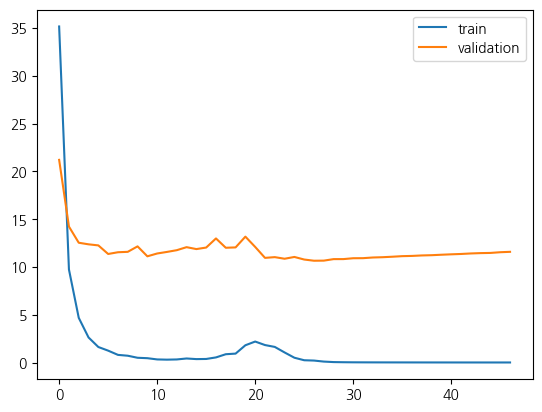

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

### 4-2. 1-D CNN

In [ ]:
# 세션 클리어
K.clear_session()

# 모델 쌓기
il = Input(shape=(500, ))

hl = Dense(64, activation='swish')(il)
hl = Dense(128, activation='swish')(hl)
hl = Dense(256, activation='swish')(hl)
ol = Dense(5, activation='softmax')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 요약
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 64)                32064     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 74693 (291.77 KB)
Trainable params: 74693 (291.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
history_cnn= model.fit(X_mor_sequence_train, y_train, validation_data=(X_mor_sequence_val, y_val), epochs=1000, callbacks=[es])

Epoch 1/1000
87/87 [==============================] - 2s 8ms/step - loss: 40.9948 - accuracy: 0.3023 - val_loss: 24.5568 - val_accuracy: 0.3635
Epoch 2/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.7384 - accuracy: 0.4019 - val_loss: 14.4373 - val_accuracy: 0.2988
Epoch 3/1000
87/87 [==============================] - 1s 7ms/step - loss: 5.4874 - accuracy: 0.5059 - val_loss: 12.0427 - val_accuracy: 0.3225
Epoch 4/1000
87/87 [==============================] - 1s 6ms/step - loss: 3.2475 - accuracy: 0.5873 - val_loss: 12.3596 - val_accuracy: 0.3236
Epoch 5/1000
87/87 [==============================] - 1s 10ms/step - loss: 1.9317 - accuracy: 0.6499 - val_loss: 11.0428 - val_accuracy: 0.3204
Epoch 6/1000
87/87 [==============================] - 1s 10ms/step - loss: 1.2106 - accuracy: 0.7406 - val_loss: 10.7784 - val_accuracy: 0.3172
Epoch 7/1000
87/87 [==============================] - 1s 9ms/step - loss: 0.8559 - accuracy: 0.7827 - val_loss: 10.9196 - val_accuracy: 0.

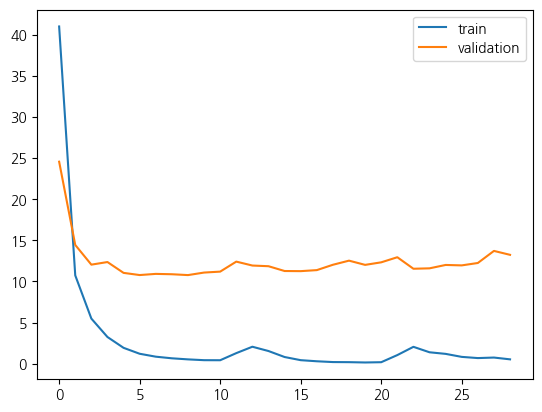

In [ ]:
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
max_words = 2993
embedding_dim = 128

# 세션 클리어
K.clear_session()

# 모델 쌓기
il = Input(shape=(500,))
hl = Embedding(max_words, embedding_dim)(il)
hl = Conv1D(64, 5, padding='same', activation='swish')(hl)
hl = Conv1D(64, 5, padding='same', activation='swish')(hl)
hl = MaxPool1D(2)(hl)

hl = Conv1D(128, 5, padding='same', activation='swish')(hl)
hl = Conv1D(128, 5, padding='same', activation='swish')(hl)
hl = MaxPool1D(2)(hl)

hl = Conv1D(256, 5, padding='same', activation='swish')(hl)
hl = Conv1D(256, 5, padding='same', activation='swish')(hl)
hl = MaxPool1D(2)(hl)
hl = Flatten()(hl)
ol = Dense(5, activation='softmax')(hl)

# 모델 선언
model = Model(il, ol)

# 컴파일
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          383104    
                                                                 
 conv1d (Conv1D)             (None, 500, 64)           41024     
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 64)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 128)          41088     
                                                             

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_mor_sequence_train, y_train, validation_data=(X_mor_sequence_val, y_val), epochs=1000, callbacks=[es])

Epoch 1/1000
87/87 [==============================] - 15s 115ms/step - loss: 1.2583 - accuracy: 0.4674 - val_loss: 1.0237 - val_accuracy: 0.5415
Epoch 2/1000
87/87 [==============================] - 7s 80ms/step - loss: 0.8676 - accuracy: 0.6304 - val_loss: 0.9952 - val_accuracy: 0.5804
Epoch 3/1000
87/87 [==============================] - 4s 47ms/step - loss: 0.6702 - accuracy: 0.7244 - val_loss: 0.9514 - val_accuracy: 0.6386
Epoch 4/1000
87/87 [==============================] - 5s 56ms/step - loss: 0.5484 - accuracy: 0.7794 - val_loss: 1.0424 - val_accuracy: 0.6073
Epoch 5/1000
87/87 [==============================] - 3s 35ms/step - loss: 0.4725 - accuracy: 0.8158 - val_loss: 1.1585 - val_accuracy: 0.6181
Epoch 6/1000
87/87 [==============================] - 3s 33ms/step - loss: 0.3335 - accuracy: 0.8881 - val_loss: 1.5788 - val_accuracy: 0.6494
Epoch 7/1000
87/87 [==============================] - 3s 32ms/step - loss: 0.2533 - accuracy: 0.9147 - val_loss: 2.1228 - val_accuracy: 0.65

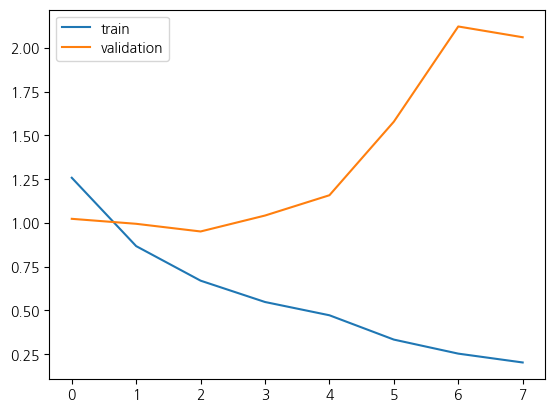

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

### 4-3. LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Flatten, Dense

max_words = 9425 - 3510 + 1
embedding_dim = 128

# 모델 초기화
model_LSTM = Sequential()

model_LSTM.add(Embedding(max_words, embedding_dim, input_length=500))

model_LSTM.add(Conv1D(64, 5, padding='same', activation='swish'))
model_LSTM.add(Conv1D(64, 5, padding='same', activation='swish'))
model_LSTM.add(MaxPooling1D(2))

model_LSTM.add(Conv1D(128, 5, padding='same', activation='swish'))
model_LSTM.add(Conv1D(128, 5, padding='same', activation='swish'))
model_LSTM.add(MaxPooling1D(2))

model_LSTM.add(LSTM(64, return_sequences=True))
model_LSTM.add(LSTM(64, return_sequences=True))
model_LSTM.add(LSTM(64, return_sequences=False))

# Flatten 레이어 추가
model_LSTM.add(Flatten())

# 출력 레이어 추가
model_LSTM.add(Dense(5, activation='softmax'))

# 컴파일
model_LSTM.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 모델 요약
model_LSTM.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 128)          757248    
                                                                 
 conv1d_6 (Conv1D)           (None, 500, 64)           41024     
                                                                 
 conv1d_7 (Conv1D)           (None, 500, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 250, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 250, 128)          41088     
                                                                 
 conv1d_9 (Conv1D)           (None, 250, 128)          82048     
                                                        

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
history_LSTM = model_LSTM.fit(X_mor_sequence_train, y_train, validation_data=(X_mor_sequence_val, y_val),
                    epochs=1000, callbacks=[es])

Epoch 1/1000
87/87 [==============================] - 18s 133ms/step - loss: 1.2361 - accuracy: 0.4700 - val_loss: 1.0632 - val_accuracy: 0.5566
Epoch 2/1000
87/87 [==============================] - 8s 95ms/step - loss: 0.8908 - accuracy: 0.6398 - val_loss: 1.0349 - val_accuracy: 0.5523
Epoch 3/1000
87/87 [==============================] - 7s 78ms/step - loss: 0.7009 - accuracy: 0.7287 - val_loss: 1.0550 - val_accuracy: 0.6095
Epoch 4/1000
87/87 [==============================] - 7s 78ms/step - loss: 0.5441 - accuracy: 0.8082 - val_loss: 1.0765 - val_accuracy: 0.6300
Epoch 5/1000
87/87 [==============================] - 5s 60ms/step - loss: 0.4729 - accuracy: 0.8338 - val_loss: 1.0311 - val_accuracy: 0.6462
Epoch 6/1000
87/87 [==============================] - 5s 61ms/step - loss: 0.3782 - accuracy: 0.8654 - val_loss: 1.2268 - val_accuracy: 0.6365
Epoch 7/1000
87/87 [==============================] - 8s 98ms/step - loss: 0.3174 - accuracy: 0.8982 - val_loss: 1.2023 - val_accuracy: 0.64

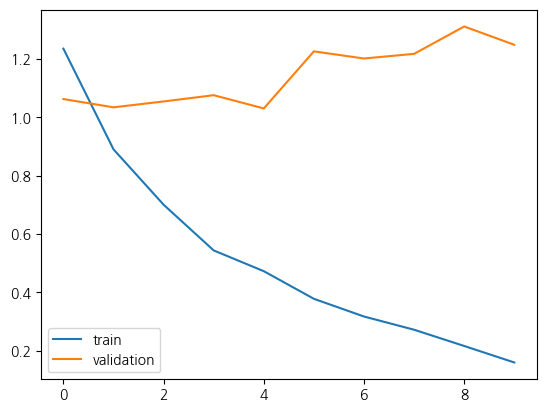

In [ ]:
plt.plot(history_LSTM.history['loss'], label='train')
plt.plot(history_LSTM.history['val_loss'], label='validation')
plt.legend()
plt.show()

## 5. Using pre-trained model(Optional)
* 한국어 pre-trained model로 fine tuning 및 성능 분석
> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
> * [HuggingFace-Korean](https://huggingface.co/models?language=korean)